In [1]:
import torch
from torch import nn
import numpy as np
import os
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_inline import backend_inline
import time
from scipy.io import loadmat
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def _u(x):
    return np.sin(x[:, 0:1] * x[:, 1:2]) * (1 - np.cos(x[:, 0:1] ** 2 + x[:, 1:2] ** 2))

In [ ]:
class MLP(nn.Module):
    def __init__(self, lst: list, act: callable = nn.Tanh):
        super().__init__()
        depth = len(lst) - 1
        layer = []
        for i in range(depth - 1):
            linear = nn.Linear(lst[i], lst[i + 1])
            layer.append(linear)
            layer.append(act())
        layer.append(nn.Linear(lst[-2], lst[-1]))
        self.layer = nn.Sequential(*layer)

    def forward(self, X):
        return self.layer(X)


model = MLP([2] + [50] * 4 + [1]).cuda()
model.load_state_dict(torch.load("./Best_SG.pt"))

<All keys matched successfully>

In [8]:
lb = np.array([-4.0])
ub = np.array([4.0])
rb = np.array([4.0])
lftb = np.array([-4.0])

In [9]:
R, S = np.meshgrid(
    np.linspace(lftb[0], rb[0], 101), np.linspace(lb[0], ub[0], 101), indexing="ij"
)
test_data = np.concatenate([R.flatten()[:, None], S.flatten()[:, None]], 1)
truth = _u(test_data).ravel()

test_data_tensor = torch.tensor(test_data, dtype=torch.float32).cuda()
predd = model(test_data_tensor).cpu().detach().numpy().ravel()
rel2 = np.linalg.norm(predd - truth, 2) / np.linalg.norm(truth, 2)
print(rel2)

0.0008420596673970926


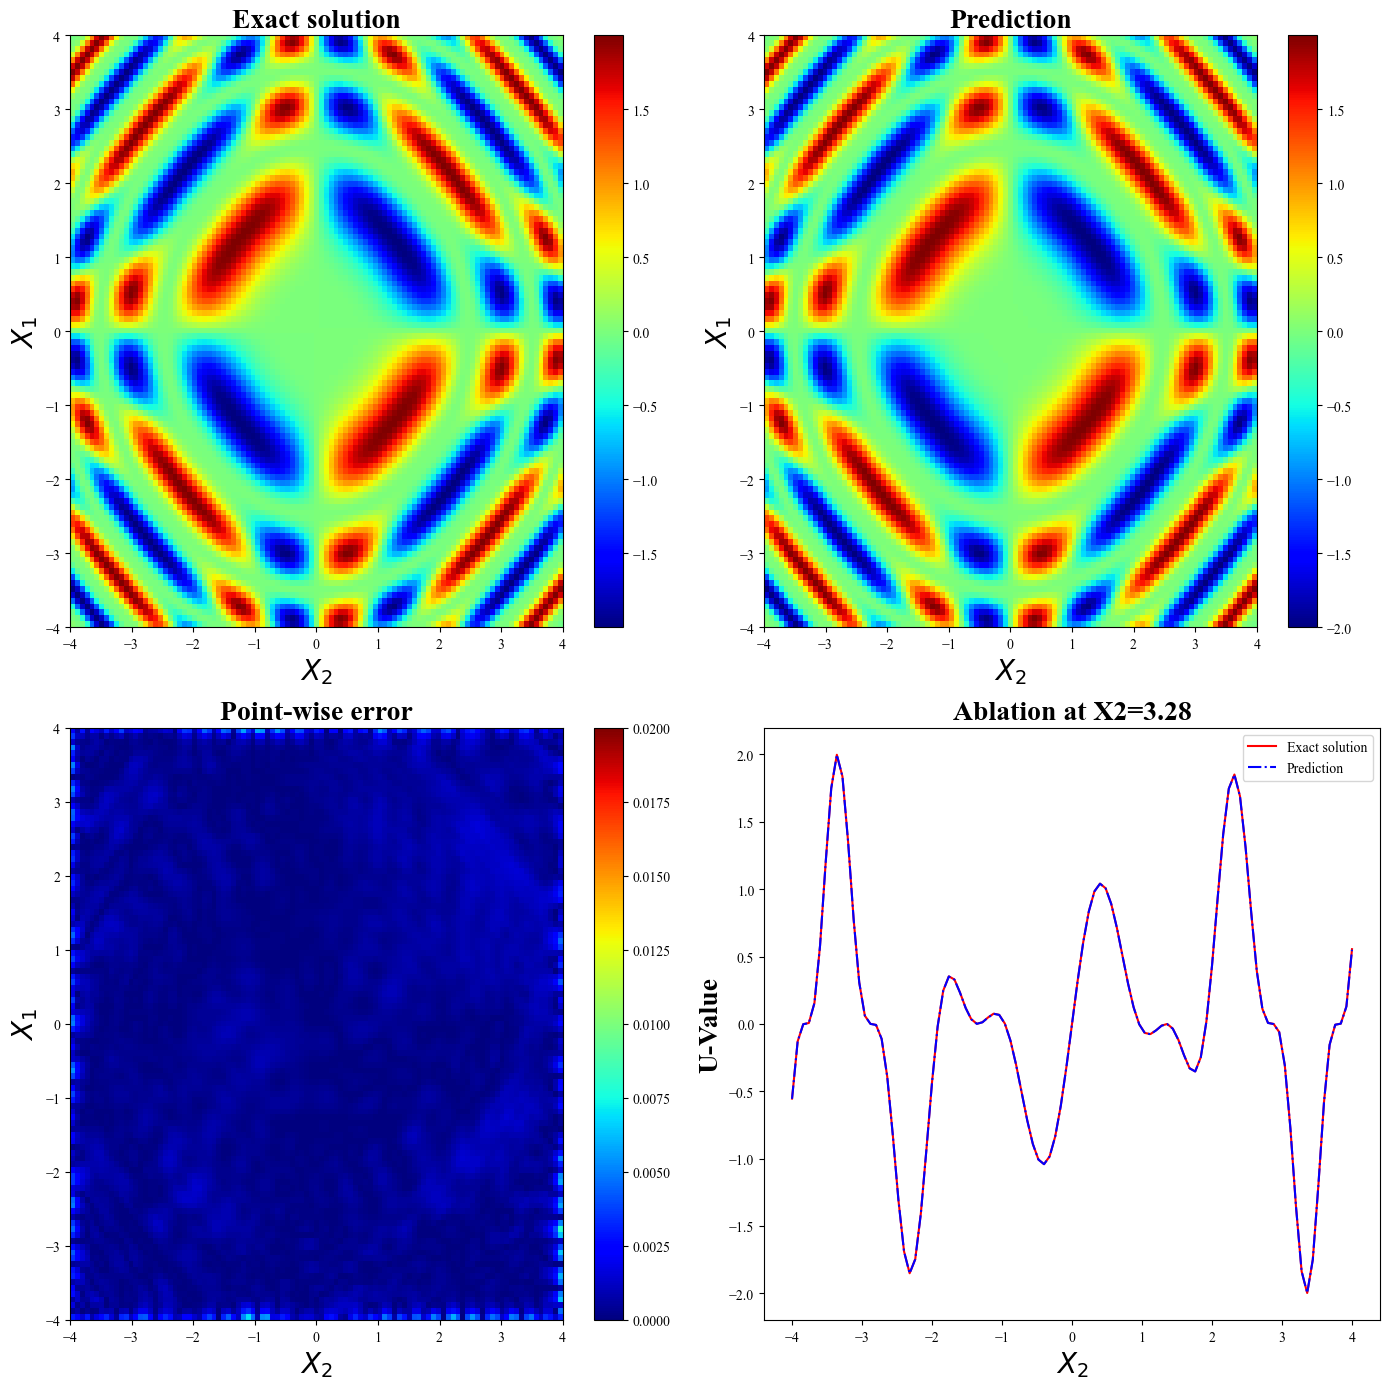

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

plt.rcParams["font.family"] = "Times New Roman"

# 假设 y_true, y_pred, X_test 已定义好
extent = [-4, 4, -4, 4]
font_dict = {
    "fontsize": 20,
    "fontweight": "bold",
    "family": "Times New Roman",  # 可选：覆盖全局字体设置
}


fig = plt.figure(figsize=(14, 14))
gs = gridspec.GridSpec(2, 2, figure=fig)

# ax1: Exact solution
ax1 = fig.add_subplot(gs[0, 0])

h1 = ax1.imshow(truth.reshape(101, 101), cmap="jet", aspect="auto", extent=extent)
ax1.set_title("Exact solution", fontdict=font_dict)
ax1.set_xlabel("$X_2$", fontdict=font_dict)
ax1.set_ylabel("$X_1$", fontdict=font_dict)
fig.colorbar(h1, ax=ax1)  # , shrink=0.6, aspect=30, pad=0.05)

# ax2: Prediction
ax2 = fig.add_subplot(gs[0, 1])
h2 = ax2.imshow(predd.reshape(101, 101), cmap="jet", aspect="auto", extent=extent)
ax2.set_title("Prediction", fontdict=font_dict)
ax2.set_xlabel("$X_2$", fontdict=font_dict)
ax2.set_ylabel("$X_1$", fontdict=font_dict)
fig.colorbar(h2, ax=ax2)  # , shrink=0.6, aspect=30, pad=0.05)

# ax3: Error
ax3 = fig.add_subplot(gs[1, 0])
h3 = ax3.imshow(
    np.abs(truth - predd).reshape(101, 101),
    cmap="jet",
    aspect="auto",
    extent=extent,
    vmin=0.0,
    vmax=2e-2,
)
ax3.set_title("Point-wise error", fontdict=font_dict)
ax3.set_xlabel("$X_2$", fontdict=font_dict)
ax3.set_ylabel("$X_1$", fontdict=font_dict)
fig.colorbar(h3, ax=ax3)  # , shrink=0.6, aspect=30, pad=0.05)

# ax4: Line plot
ax4 = fig.add_subplot(gs[1, 1])
tmp = test_data[:, 1][-10]
indexs = test_data[:, 1] == tmp
line_pred = predd.ravel()[indexs]
line_truth = truth.ravel()[indexs]
x_line = np.linspace(-4, 4, len(line_truth))
ax4.plot(x_line, line_truth, "r-", label="Exact solution")
ax4.plot(x_line, line_pred, "b-.", label="Prediction")
ax4.set_xlabel("$X_2$", fontdict=font_dict)
ax4.set_ylabel("U-Value", fontdict=font_dict)
ax4.set_title(f"Ablation at X2={tmp:.2f}", fontdict=font_dict)
ax4.legend()

plt.tight_layout()
plt.savefig("Ours_SG_ALL.pdf")
plt.show()